In [1]:
import numpy as np 
import scanpy as sc 
import pandas as pd 
import biomart

In [2]:
# import anndata2ri
# import logging

# import rpy2.rinterface_lib.callbacks as rcb
# import rpy2.robjects as ro
# import rpy2.robjects.packages as rpackages

# rcb.logger.setLevel(logging.ERROR)
# ro.pandas2ri.activate()
# anndata2ri.activate()

# %load_ext rpy2.ipython

In [4]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')
# utils.chooseCRANmirror(ind=1)
# utils.install_packages("biomaRt")
# biomaRt = rpackages.importr("biomaRt")

# Introduction 
 In this notebook we will be working on the mouse embryonic stem cells(mESCs). The working steps and goals as follows;
   - Filtering and normalizing the data.
   - Visualize the data in UMAP and PC space and find a suitable way to visualize the marker genes of the clusters.
   - Visualizing batches and the conditions in UMAP.
  
 The datasets can be download from the link: [ESpresso Teichlab](https://espresso.teichlab.sanger.ac.uk). We will be working on the raw [data](https://espresso.teichlab.sanger.ac.uk/static/counttable_es.csv).
 Our guide will be the Scanpy [Preprocessing and Clustering](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) documentation.
     
 


## Reading and investigation on the data.

In [2]:
adata = sc.read_csv("/Users/omercagatay/Desktop/Courses/Cmscb/Project/datasets/counttable_es.csv", delimiter=" ", first_column_names=True)

- The raw data only consists ensemble-id's. By using the biomart library ensemble-id's can be matched with gene symbols.

 --- 
Basics of annData:
* .var : pd df, annotation of var's
* .X : np array, obsxvar 
* .obs : pd df, annotation of obs's 
* .uns : dict, unstruct annotation 

In [3]:
# Taken from: https://autobencoder.com/2021-10-03-gene-conversion/#python

def get_ensembl_mappings():                                   
    # Set up connection to server                                               
    server = biomart.BiomartServer('http://uswest.ensembl.org/biomart')         
    mart = server.datasets['mmusculus_gene_ensembl']                            
                                                                                
    # List the types of data we want                                            
    attributes = ['ensembl_transcript_id', 'mgi_symbol', 
                  'ensembl_gene_id', 'ensembl_peptide_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    ensembl_to_genesymbol = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        # The entries are in the same order as in the `attributes` variable
        transcript_id = line[0]                                                 
        gene_symbol = line[1]                                                   
        ensembl_gene = line[2]                                                  
        ensembl_peptide = line[3]                                               
                                                                                
        # Some of these keys may be an empty string. If you want, you can 
        # avoid having a '' key in your dict by ensuring the 
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl_to_genesymbol[transcript_id] = gene_symbol                      
        ensembl_to_genesymbol[ensembl_gene] = gene_symbol                       
        ensembl_to_genesymbol[ensembl_peptide] = gene_symbol                
                                                                                
    return ensembl_to_genesymbol

In [4]:
ensemble_dict = get_ensembl_mappings()

In [5]:
df = adata.to_df().reset_index().rename(columns={'index': 'ENSEMBL'}).copy()
df['SYMBOL'] = df['ENSEMBL'].apply(lambda x: ensemble_dict.get(x, x))
cols = df.columns.tolist()
cols = cols[0:1] + cols[-1:] + cols[1:-1] 
df=df[cols]
df.head()

,ENSEMBL,SYMBOL,ola_mES_2i_2_1.counts,ola_mES_2i_2_10.counts,ola_mES_2i_2_11.counts,ola_mES_2i_2_12.counts,ola_mES_2i_2_13.counts,ola_mES_2i_2_14.counts,ola_mES_2i_2_15.counts,ola_mES_2i_2_16.counts,...,ola_mES_lif_3_84.counts,ola_mES_lif_3_87.counts,ola_mES_lif_3_88.counts,ola_mES_lif_3_89.counts,ola_mES_lif_3_9.counts,ola_mES_lif_3_90.counts,ola_mES_lif_3_92.counts,ola_mES_lif_3_94.counts,ola_mES_lif_3_95.counts,ola_mES_lif_3_96.counts
0,ENSMUSG00000000001,Gnai3,272.0,368.0,1431.0,2249.0,385.0,1053.0,1424.0,1117.0,...,211.0,251.0,71.0,40.0,620.0,1235.0,255.0,1142.0,644.0,278.0
1,ENSMUSG00000000003,Pbsn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSMUSG00000000028,Cdc45,271.0,983.0,1248.0,971.0,1149.0,432.0,2406.0,863.0,...,91.0,175.0,11.0,55.0,228.0,122.0,126.0,60.0,161.0,39.0
3,ENSMUSG00000000031,H19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,469.0,32.0,3.0,1729.0,55.0,0.0,25.0,214.0
4,ENSMUSG00000000037,Scml2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
symbols=df.SYMBOL.to_list()
adata.obs["symbol"] = pd.Categorical(symbols)

## Some Cleaning
Some columns expressed "bad observations". So better to get rid of them. 


In [7]:
print([name for name in symbols if name.startswith('__')])

['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']


In [8]:
symbols_wanted = [name for name in symbols if not name.startswith('__')]
adata = adata[adata.obs['symbol'].isin(symbols_wanted)]

In [9]:
adata.var_names_make_unique()
adata_t = adata.T
adata_t.var_names_make_unique()

In [10]:
print("obs-cells: ", adata_t.obs_names[:5].tolist())
# print(adata.obs_names[-5:].tolist())
print("var-genes: ", adata_t.var['symbol'][:5].tolist())
print(adata_t.var_names[-5:].tolist())

obs-cells:  ['ola_mES_2i_2_1.counts', 'ola_mES_2i_2_10.counts', 'ola_mES_2i_2_11.counts', 'ola_mES_2i_2_12.counts', 'ola_mES_2i_2_13.counts']
var-genes:  ['Gnai3', 'Pbsn', 'Cdc45', 'H19', 'Scml2']
['ERCC-00164', 'ERCC-00165', 'ERCC-00168', 'ERCC-00170', 'ERCC-00171']


# Filtering 

In [11]:
print("Before filtering: ",adata_t)
sc.pp.filter_cells(adata_t, min_genes=200)
sc.pp.filter_genes(adata_t, min_cells=5)
print("After filtering: ",adata_t)

Before filtering:  AnnData object with n_obs × n_vars = 704 × 38653
    var: 'symbol'
After filtering:  AnnData object with n_obs × n_vars = 704 × 26034
    obs: 'n_genes'
    var: 'symbol', 'n_cells'


- With the parameters used, while the number of cells stayed same, number of genes were reduced to 26037 from 38658. 

# Genes that has highest fraction of the counts.

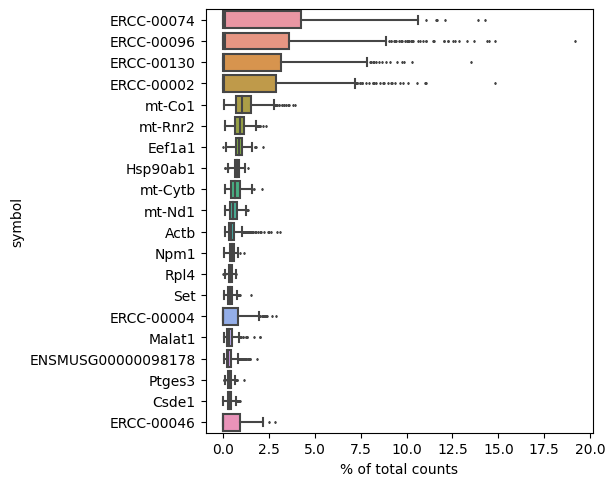

In [12]:
sc.pl.highest_expr_genes(adata_t, n_top=20, gene_symbols= 'symbol')

The genes stars with "ERCC" are representing the control genes. For better undurstanding of the dataset I will also remove them.

In [15]:
print([name for name in symbols if name.startswith('ERCC')])

['ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016', 'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024', 'ERCC-00025', 'ERCC-00028', 'ERCC-00031', 'ERCC-00033', 'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040', 'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044', 'ERCC-00046', 'ERCC-00048', 'ERCC-00051', 'ERCC-00053', 'ERCC-00054', 'ERCC-00057', 'ERCC-00058', 'ERCC-00059', 'ERCC-00060', 'ERCC-00061', 'ERCC-00062', 'ERCC-00067', 'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074', 'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078', 'ERCC-00079', 'ERCC-00081', 'ERCC-00083', 'ERCC-00084', 'ERCC-00085', 'ERCC-00086', 'ERCC-00092', 'ERCC-00095', 'ERCC-00096', 'ERCC-00097', 'ERCC-00098', 'ERCC-00099', 'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111', 'ERCC-00112', 'ERCC-00113', 'ERCC-00116', 'ERCC-00117', 'ERCC-00120', 'ERCC-00123', 'ERCC-00126', 'ERCC-00130', 'ERCC-00131', 'ERCC-00134', 'ERCC-00136', 'ERCC

In [18]:
symbols_wanted = [name for name in symbols if not name.startswith('ERCC')]
adata = adata[adata.obs['symbol'].isin(symbols_wanted)]

In [22]:
adata.var_names_make_unique()
adata_t=adata.T

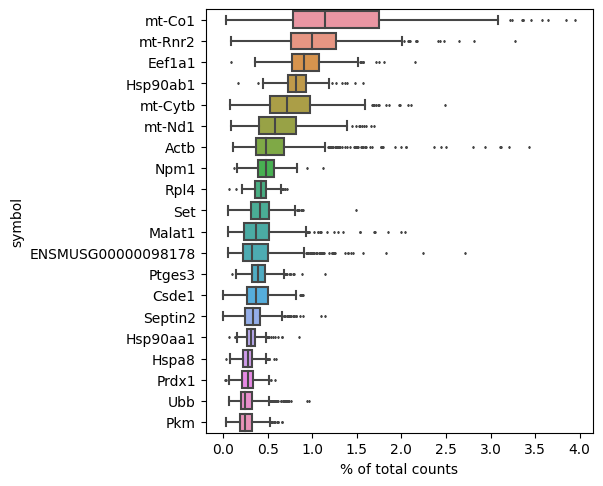

In [23]:
sc.pl.highest_expr_genes(adata_t, n_top=20, gene_symbols= 'symbol')

# Annotations 

## Determining the mithocondrial genes, batches, media and the cell id's.

In [25]:
adata_t.var['mt'] =  adata_t.var['symbol'].str.startswith('mt')
colnames=adata_t.obs.index.values
adata_t.obs["media"] = [it.split("_")[2] for it in colnames]
adata_t.obs["batch_id"] = [it.split("_")[3] for it in colnames]
adata_t.obs["cell_id"] = [it.split("_")[4].split(".")[0] for it in colnames]

# Calculating Metrics

In [26]:
sc.pp.calculate_qc_metrics(adata_t, qc_vars=['mt'], percent_top = None, log1p = False, inplace= True)

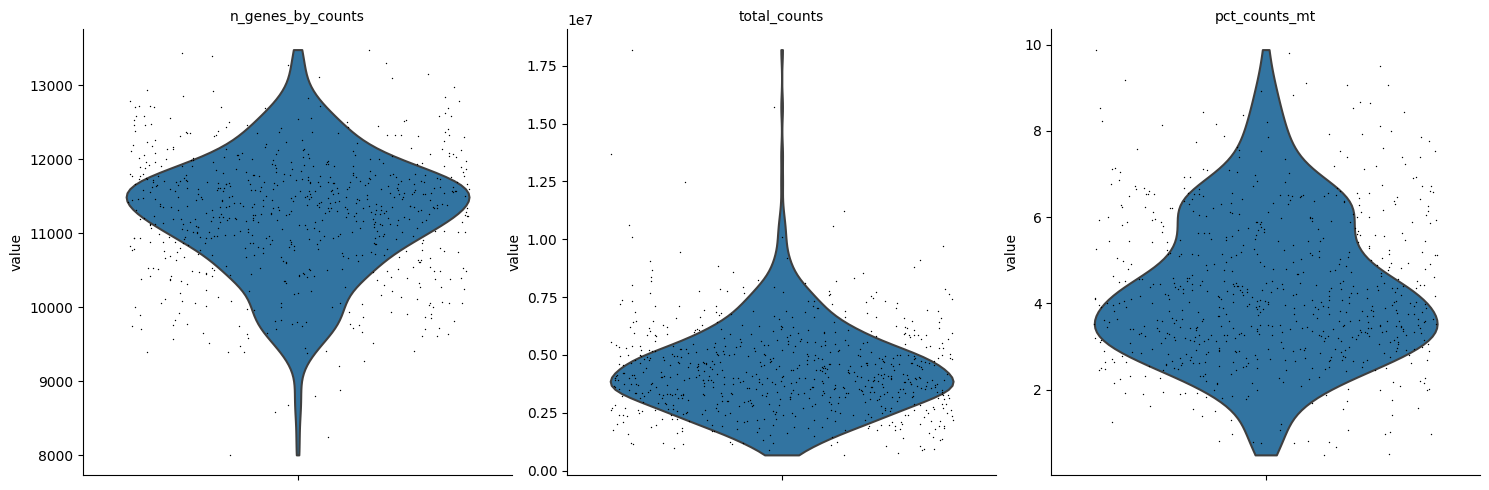

In [27]:
sc.pl.violin(adata_t, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [28]:
import matplotlib.pyplot as plt

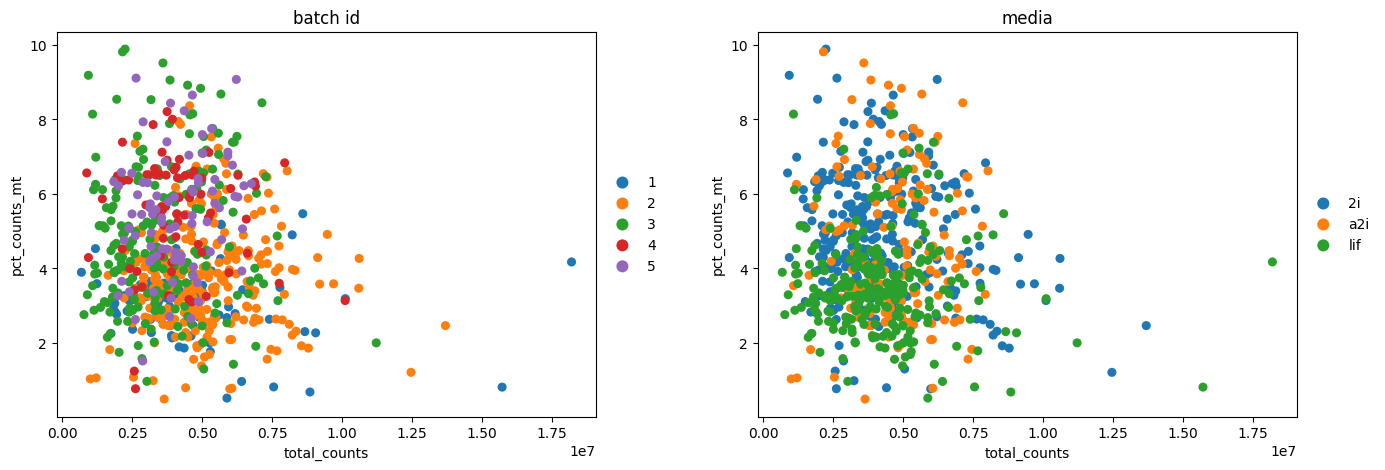

In [29]:
fig, (p1, p2) = plt.subplots(1, 2, figsize=(16,5), gridspec_kw={'wspace':0.3})
p1 = sc.pl.scatter(adata_t, x='total_counts', y='pct_counts_mt',color='batch_id', ax = p1, show= False)
p2 = sc.pl.scatter(adata_t, x='total_counts', y='pct_counts_mt',color='media', ax = p2, show= False)

## Slicing and Total-count Normalization
- After the operations we will search for highly variable genes again.

In [30]:
data= adata_t[adata_t.obs.n_genes_by_counts < 13000, :]
data= adata_t[adata_t.obs.pct_counts_mt < 5, :]
data_1e4 = data.copy()

I created the copy of the data to observe the effect of the target_sum parameter in the normalization step.

In [31]:
sc.pp.normalize_total(data, target_sum=1e6)
sc.pp.normalize_total(data_1e4, target_sum=1e4)

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [32]:
sc.pp.log1p(data)
sc.pp.log1p(data_1e4)

In [33]:
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(data_1e4, min_mean=0.0125, max_mean=3, min_disp=0.5)

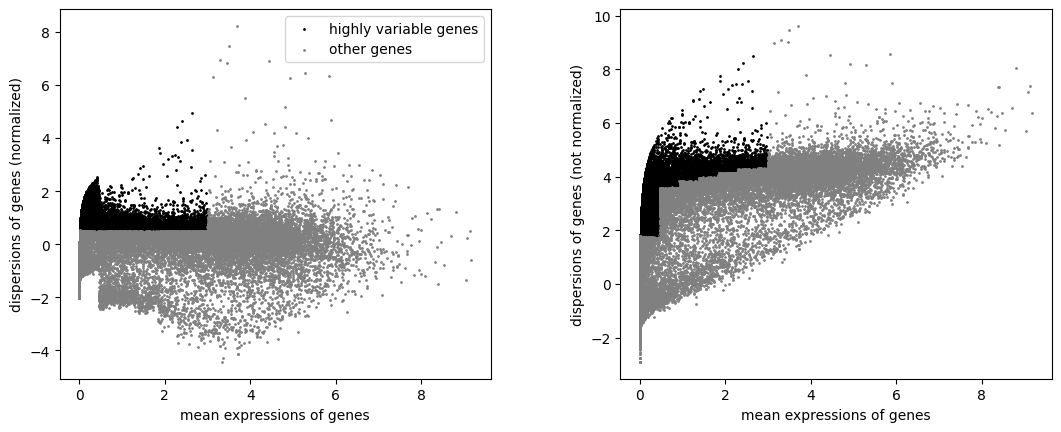

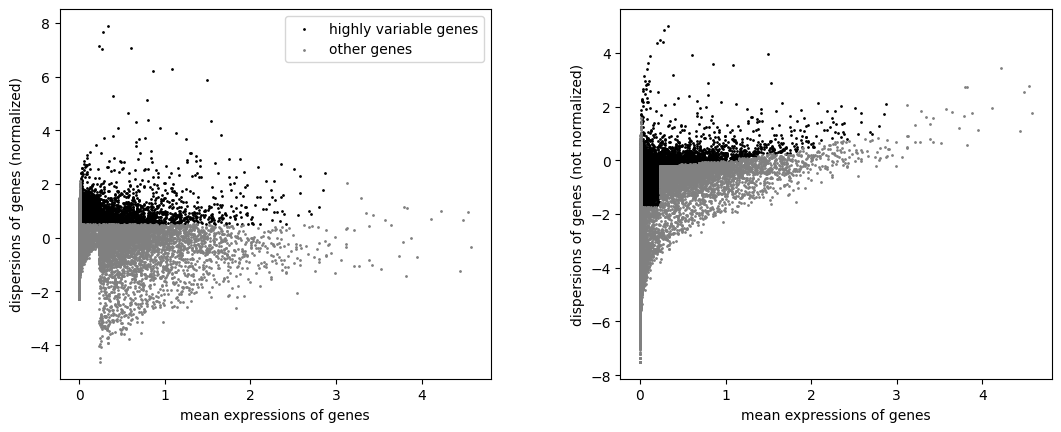

In [34]:
sc.pl.highly_variable_genes(data)
sc.pl.highly_variable_genes(data_1e4)

In [35]:
print("Before filtering by the highly var. genes for data_1e6: ", data.X.shape)
print("Before filtering by the highly var. genes for data_1e4: ", data_1e4.X.shape)
data = data[:, data.var.highly_variable]
data_1e4 = data_1e4[:, data_1e4.var.highly_variable]
print("After fitering data_1e6: ", data)
print("After fitering data_1e4: ", data_1e4)

Before filtering by the highly var. genes for data_1e6:  (476, 38561)
Before filtering by the highly var. genes for data_1e4:  (476, 38561)
After fitering data_1e6:  View of AnnData object with n_obs × n_vars = 476 × 8569
    obs: 'media', 'batch_id', 'cell_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_id_colors', 'media_colors', 'log1p', 'hvg'
After fitering data_1e4:  View of AnnData object with n_obs × n_vars = 476 × 7861
    obs: 'media', 'batch_id', 'cell_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_id_colors', 'media_colors', 'log1p', 'hvg'


In [36]:
sc.pp.scale(data, max_value=10)
sc.pp.scale(data_1e4, max_value=10)

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# PCA

In [37]:
sc.tl.pca(data, svd_solver='arpack')
sc.tl.pca(data_1e4, svd_solver='arpack')


/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


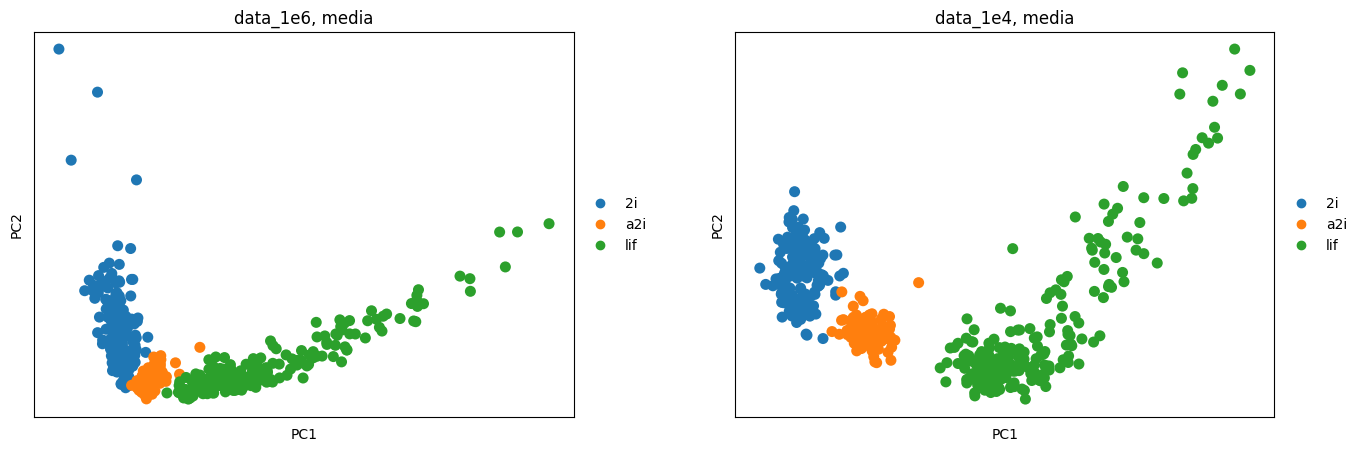

In [38]:
fig, (p1, p2) = plt.subplots(1, 2, figsize=(16,5), gridspec_kw={'wspace':0.3})
p1 = sc.pl.pca(data, color= 'media', ax = p1, show= False, title='data_1e6, media')
p2 = sc.pl.pca(data_1e4, color= 'media', ax = p2, show= False,title='data_1e4, media')

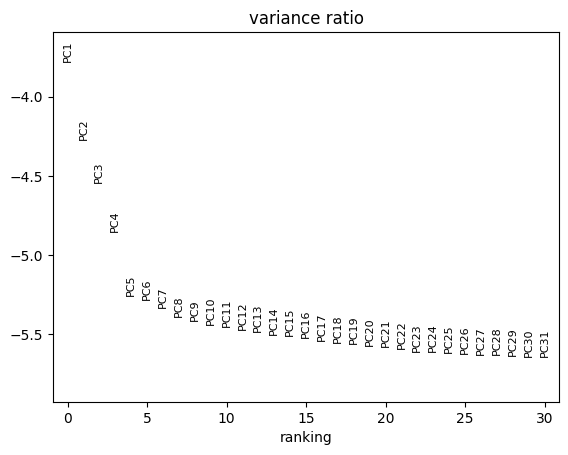

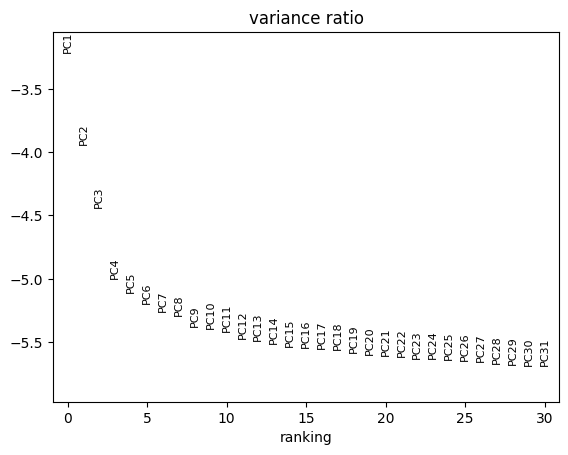

In [39]:
p1 = sc.pl.pca_variance_ratio(data, log=True )
p2 = sc.pl.pca_variance_ratio(data_1e4, log=True)

Looking the pca graphs we see that the tarket sum 1e4 is more helpfull. I will continue working on it.

# Computing the neighborhood graph

In [40]:
sc.pp.neighbors(data_1e4, n_neighbors=10, n_pcs=40)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [41]:
sc.tl.leiden(data_1e4)

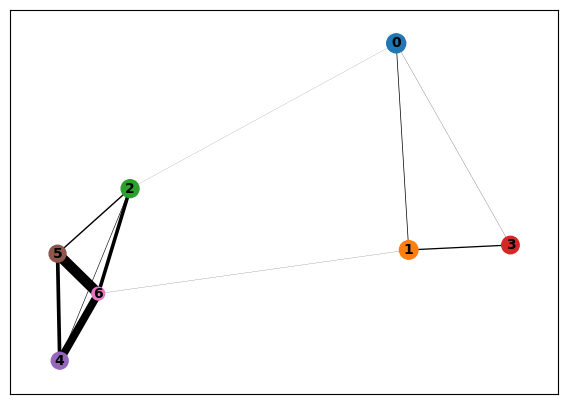

In [42]:
sc.tl.paga(data_1e4)
sc.pl.paga(data_1e4, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(data_1e4, init_pos='paga')

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


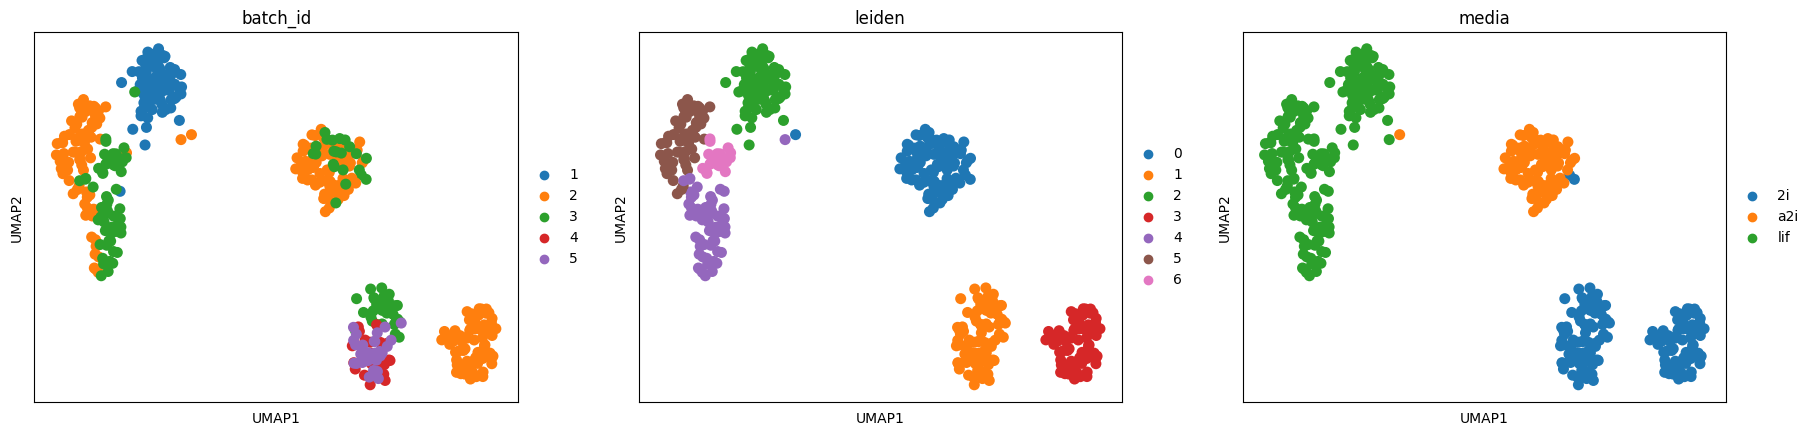

In [43]:
sc.pl.umap(data_1e4, color=['batch_id', 'leiden', 'media'],use_raw=False)

## Finding marker genes

- question: how we can work with an column in data.var but not with the index?

# Marker genes-media

In [44]:
data_1e4.var = data_1e4.var.reset_index().rename(columns={'index': 'ensembl_id'}).set_index('symbol')
data_1e4.var.index = data_1e4.var.index.astype(str)
data_1e4.var_names_make_unique()

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Gnai3', 'Cdc45', 'H19', 'Scml2', 'Narf']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [45]:
data_p= data_1e4.copy()

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


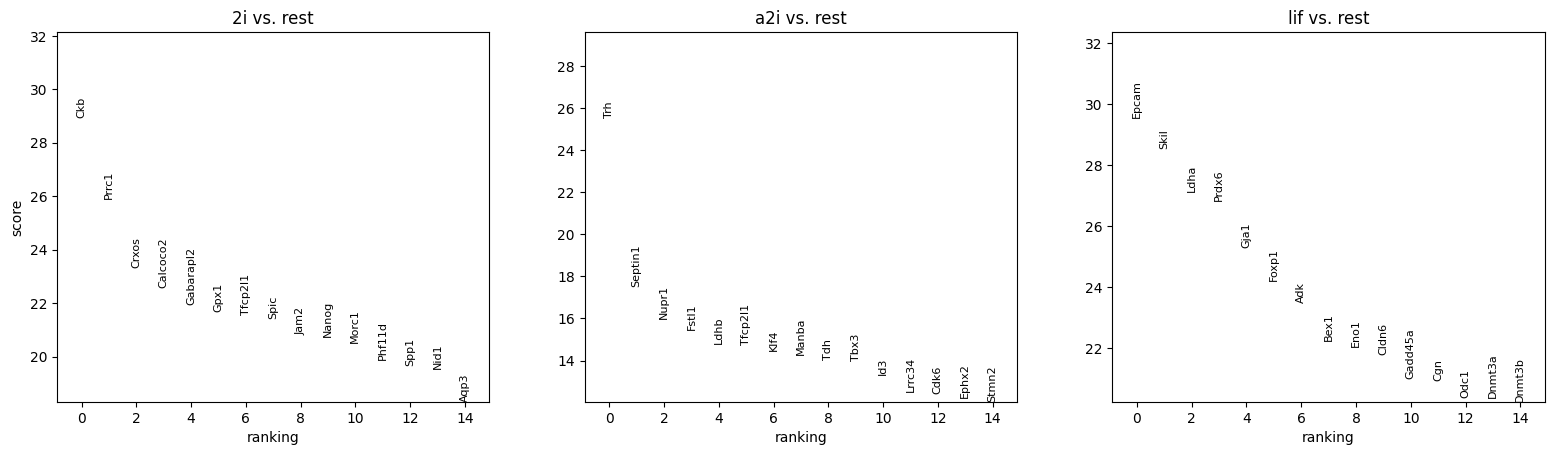

In [46]:
 sc.tl.rank_genes_groups(data_1e4, 'media', method='t-test')
# sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data_1e4, n_genes=15, sharey=False)

In [47]:
pd.DataFrame(data_1e4.uns['rank_genes_groups']['names']).head()

,2i,a2i,lif
0,Ckb,Trh,Epcam
1,Prrc1,Septin1,Skil
2,Crxos,Nupr1,Ldha
3,Calcoco2,Fstl1,Prdx6
4,Gabarapl2,Ldhb,Gja1


In [48]:
marker_genes_dict = {}
dict_keys = data_1e4.obs.media.value_counts().sort_index().index.astype('str')
for count, media in enumerate(dict_keys):
    marker_genes_dict[media] = pd.DataFrame(data_1e4.uns['rank_genes_groups']['names']).iloc[:5,count].tolist()
marker_genes_dict

{'2i': ['Ckb', 'Prrc1', 'Crxos', 'Calcoco2', 'Gabarapl2'],
 'a2i': ['Trh', 'Septin1', 'Nupr1', 'Fstl1', 'Ldhb'],
 'lif': ['Epcam', 'Skil', 'Ldha', 'Prdx6', 'Gja1']}

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


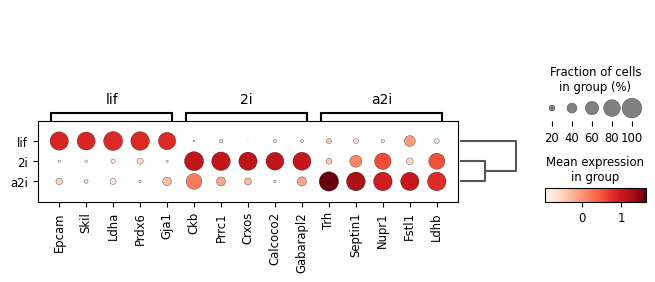

In [49]:
sc.pl.dotplot(data_1e4, marker_genes_dict, 'media', dendrogram=True)
# Bmp4 

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


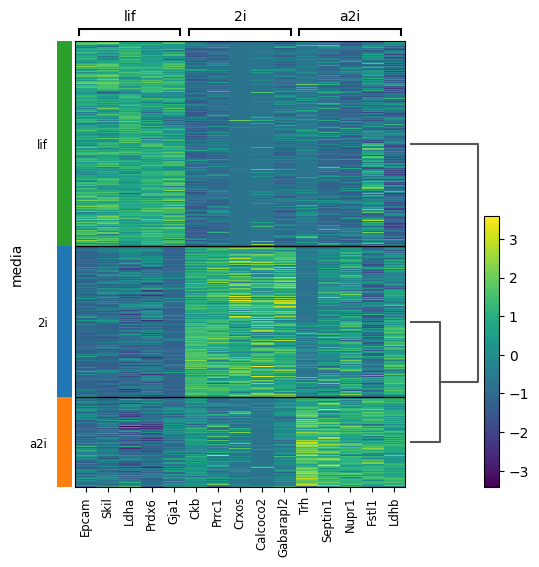

In [50]:
sc.pl.heatmap(data_1e4, marker_genes_dict, groupby='media', cmap='viridis', dendrogram=True)

## Marker genes - leiden

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

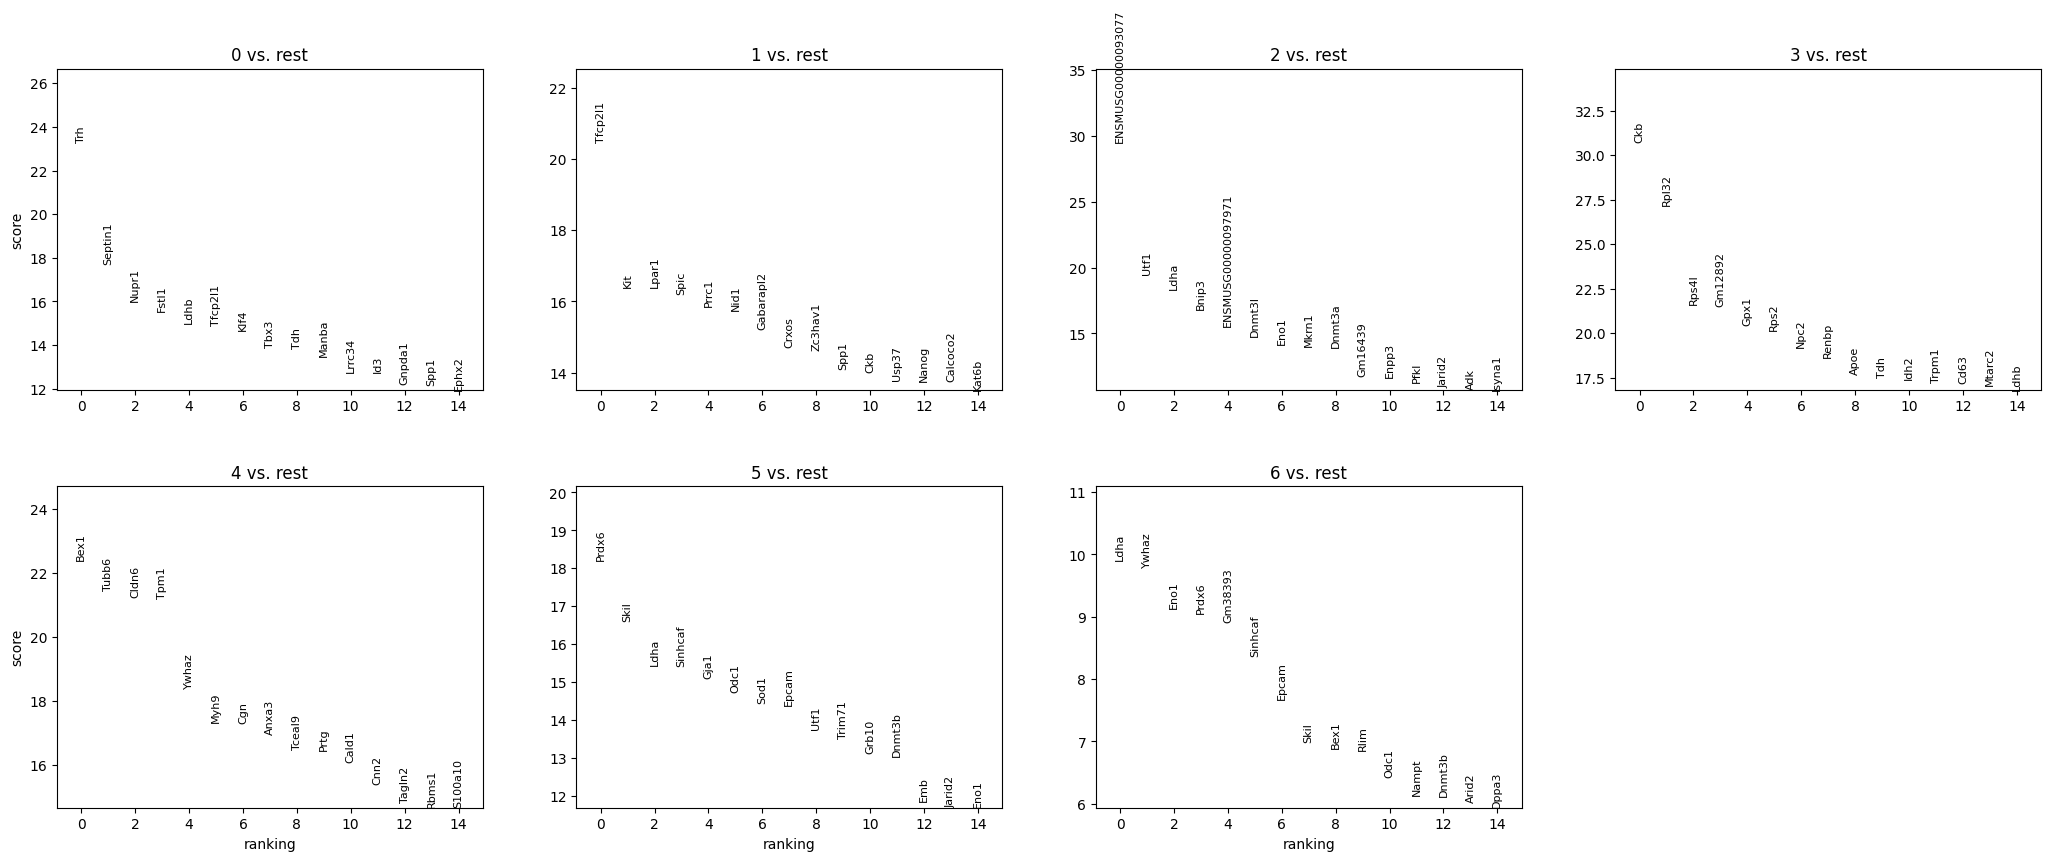

In [51]:
sc.tl.rank_genes_groups(data_p, 'leiden', method='t-test')
# sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data_p, n_genes=15, sharey=False)

In [52]:
pd.DataFrame(data_p.uns['rank_genes_groups']['names']).head()

,0,1,2,3,4,5,6
0,Trh,Tfcp2l1,ENSMUSG00000093077,Ckb,Bex1,Prdx6,Ldha
1,Septin1,Kit,Utf1,Rpl32,Tubb6,Skil,Ywhaz
2,Nupr1,Lpar1,Ldha,Rps4l,Cldn6,Ldha,Eno1
3,Fstl1,Spic,Bnip3,Gm12892,Tpm1,Sinhcaf,Prdx6
4,Ldhb,Prrc1,ENSMUSG00000097971,Gpx1,Ywhaz,Gja1,Gm38393


In [53]:
marker_genes_dict = {}
leiden_group_count = data_p.obs.leiden.value_counts().count()
keys = range(leiden_group_count)
key = [format(x,'d') for x in keys]
for i in key:
        marker_genes_dict[i] = pd.DataFrame(data_p.uns['rank_genes_groups']['names']).iloc[:5,int(i)].tolist()

In [54]:
marker_genes_dict

{'0': ['Trh', 'Septin1', 'Nupr1', 'Fstl1', 'Ldhb'],
 '1': ['Tfcp2l1', 'Kit', 'Lpar1', 'Spic', 'Prrc1'],
 '2': ['ENSMUSG00000093077', 'Utf1', 'Ldha', 'Bnip3', 'ENSMUSG00000097971'],
 '3': ['Ckb', 'Rpl32', 'Rps4l', 'Gm12892', 'Gpx1'],
 '4': ['Bex1', 'Tubb6', 'Cldn6', 'Tpm1', 'Ywhaz'],
 '5': ['Prdx6', 'Skil', 'Ldha', 'Sinhcaf', 'Gja1'],
 '6': ['Ldha', 'Ywhaz', 'Eno1', 'Prdx6', 'Gm38393']}

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


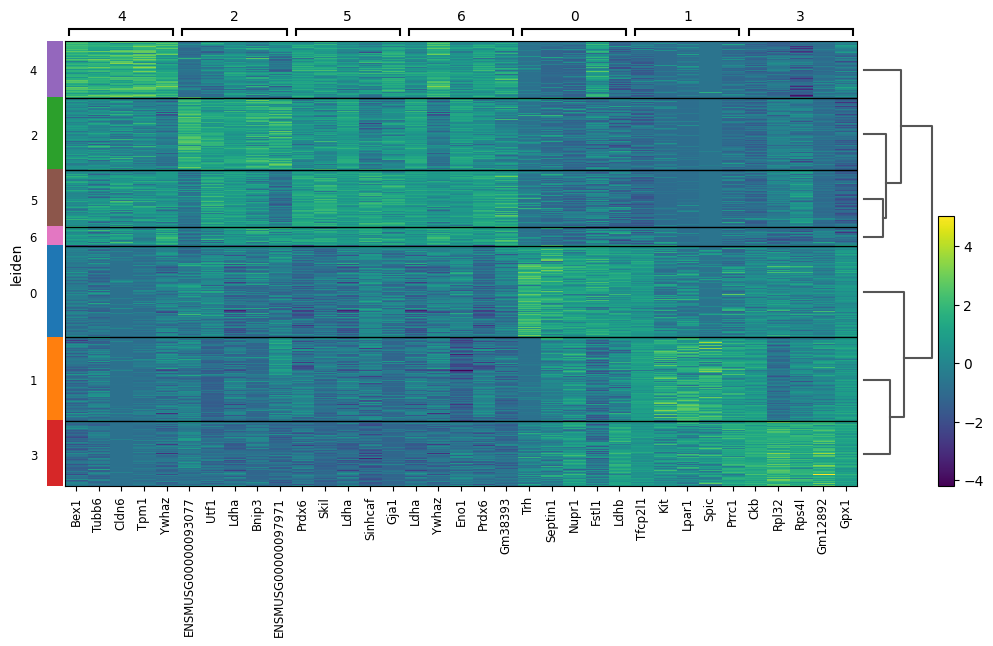

In [55]:
sc.pl.heatmap(data_p, marker_genes_dict, groupby='leiden', cmap='viridis', dendrogram=True)

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


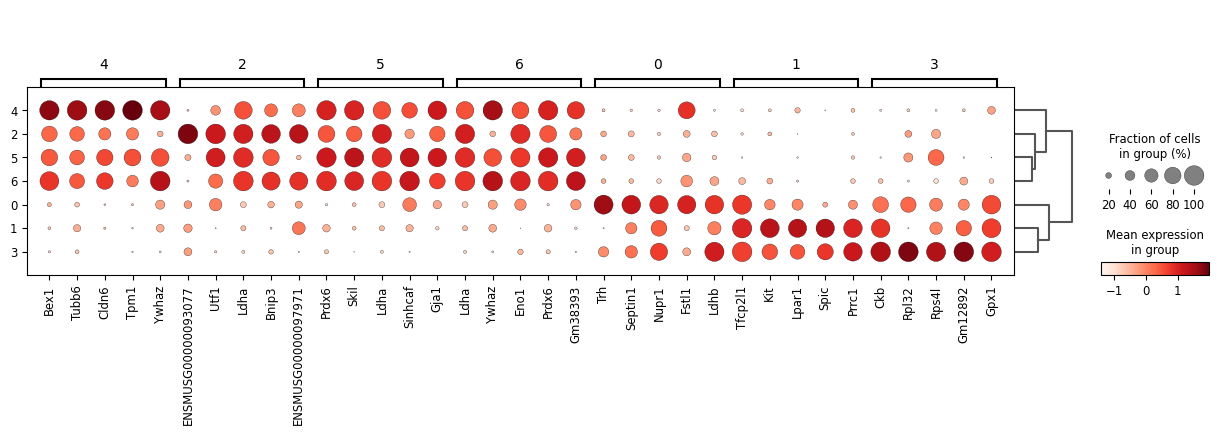

In [56]:
sc.pl.dotplot(data_p, marker_genes_dict, 'leiden', dendrogram=True)

/opt/anaconda3/envs/preprocessing/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


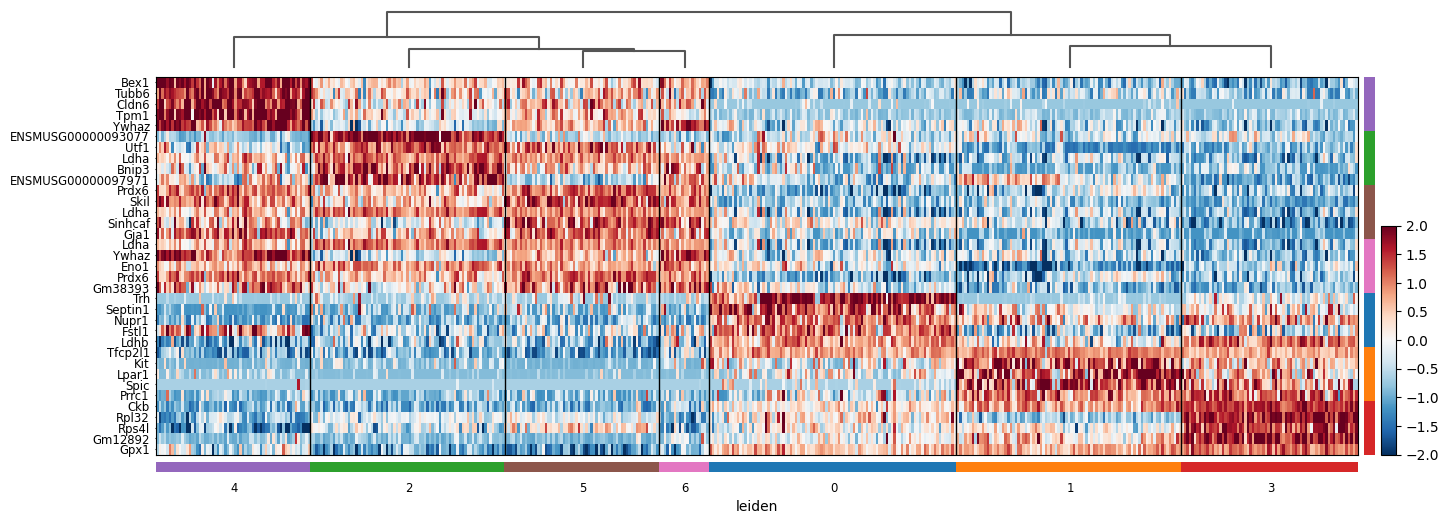

In [57]:
ax = sc.pl.heatmap(data_p, marker_genes_dict, groupby='leiden', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=True, swap_axes=True, figsize=(16,6))

Interpretation of the heatmaps will be added. 

### Notes 
UMI : Unique Molecular Identifier